In [62]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20168a20>,
      dtype=object)

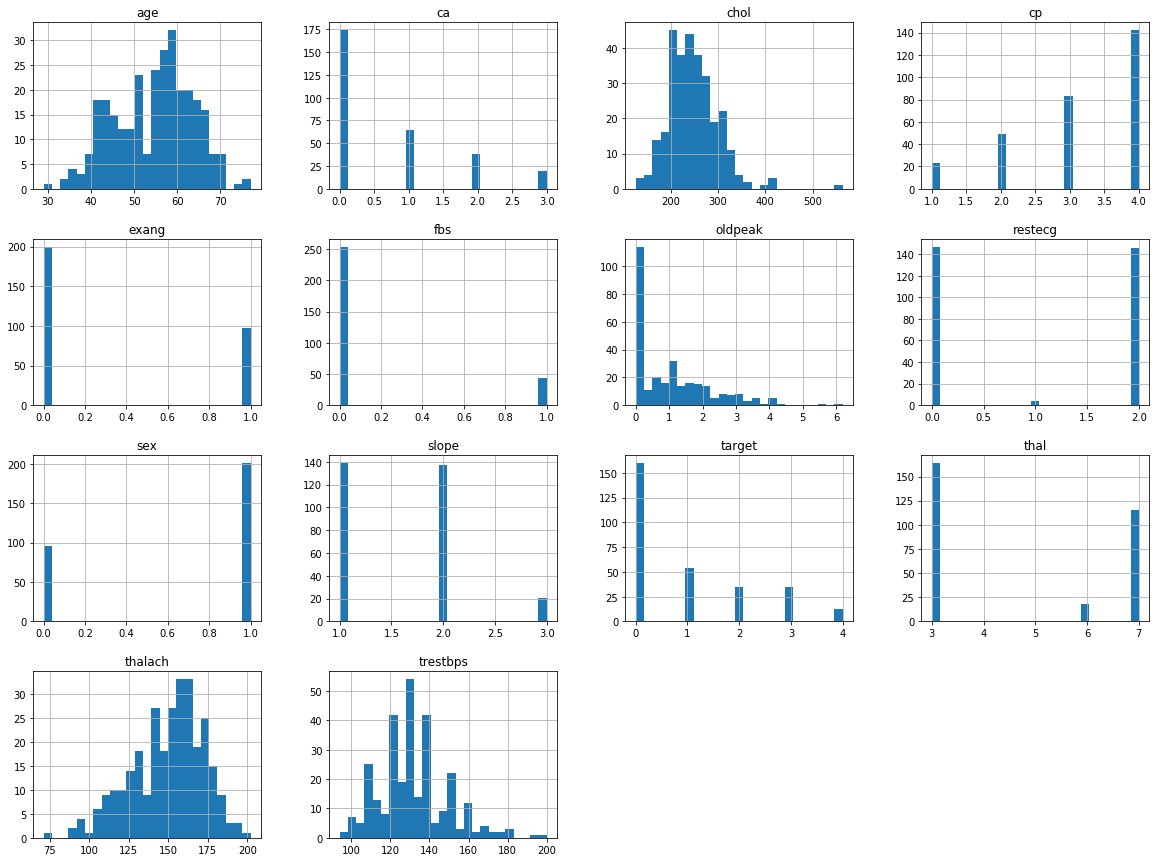

In [4]:
# raw_data = pd.read_csv("data/heart.csv")
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()

raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)
raw_data.hist(bins=25, figsize=(20,15))

In [5]:
# Categorical Types:
# Binary: sex, exang, fbs
# Multiclass: cp, restecg, thal

original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_data = pd.get_dummies(original_data, 
                               columns=["cp","restecg","thal"],
                               prefix=["cp","restecg","thal"])
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
0,63,1,145,233,1,150,0,3,0,2.3,1,0,0,0,0,0,1,0,1,0
1,67,1,160,286,0,108,1,2,3,1.5,0,0,0,1,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2,2,2.6,0,0,0,1,0,0,1,0,0,1
3,37,1,130,250,0,187,0,3,0,3.5,0,0,1,0,1,0,0,1,0,0
4,41,0,130,204,0,172,0,1,0,1.4,0,1,0,0,0,0,1,1,0,0


In [6]:
original_data.shape

(297, 20)

In [7]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

#     dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 25, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [8]:
## Need to define a scaling function that ignores categorical values...?

In [9]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,227
Trainable params: 1,227
Non-trainable params: 0
___________________

Using TensorFlow backend.


In [10]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.455, Acc:0.8915
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.535 accuracy=0.8571
Fold Correct: 24
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.496, Acc:0.8605
Prediction Accuracy
28/28 [==============================] - 0s 23us/step
Scores on data set: loss=0.458 accuracy=0.8929
Fold Correct: 25
Running worker: 2
Fold: 2 -> Loss:0.437, Acc:0.8760
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.660 accuracy=0.8571
Fold Correct: 24
Running worker: 3
Fold: 3 -> Loss:0.464, Acc:0.8798
Prediction Accuracy
27/27 [==============================] - 0s 21us/step
Scores on data set: loss=0.606 accuracy=0.8148
Fold Correct: 22
Running worker: 4
Fold: 4 -> Loss:0.399, Acc:0.9000
Prediction Accuracy
26/26 [=====

Confusion matrix, without normalization
[[0.88888889 0.11111111]
 [0.20325203 0.79674797]]


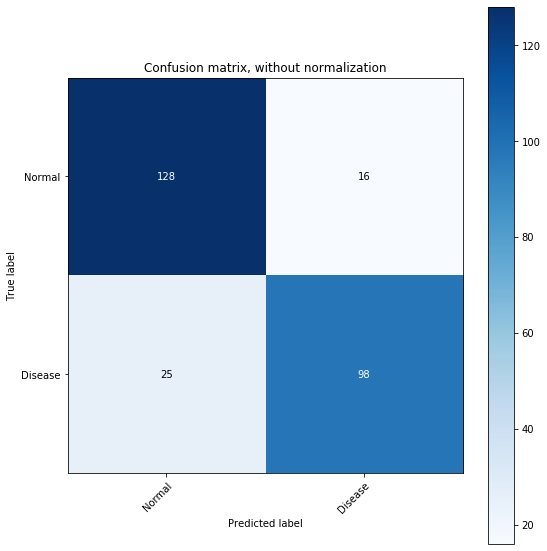

In [19]:
_, cm = plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [25]:
raw_acc = np.trace(cm)/sum(cm.ravel())
print("Overall Accuracy: {:.4f}".format(raw_acc))

Overall Accuracy: 0.8464


In [26]:
# min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(class_label=1, plot=False)

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.0,0.213065,0.213065
"(13, 12)",2,0.0,0.213065,0.213065
"(13, 13)",2,0.0,0.213065,0.213065
"(14, 12)",2,0.0,0.213065,0.213065
"(14, 13)",2,0.0,0.213065,0.213065
"(14, 14)",2,0.0,0.213065,0.213065
"(15, 12)",2,0.0,0.213065,0.213065
"(15, 13)",2,0.0,0.213065,0.213065
"(15, 14)",2,0.0,0.213065,0.213065
"(15, 15)",2,0.0,0.213065,0.213065


In [27]:
pipeline.training_lrp.shape

(98, 20)

In [28]:
pd.Series(pipeline.clusterer.labels_).value_counts()

0    57
1    41
dtype: int64

In [29]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

In [30]:
pd.Series(cluster_labels).value_counts()

0    11
dtype: int64

In [31]:
pipeline.target_class

1

## Plotting Relevance Clusters

In [32]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp
training_lrp.shape

(98, 20)

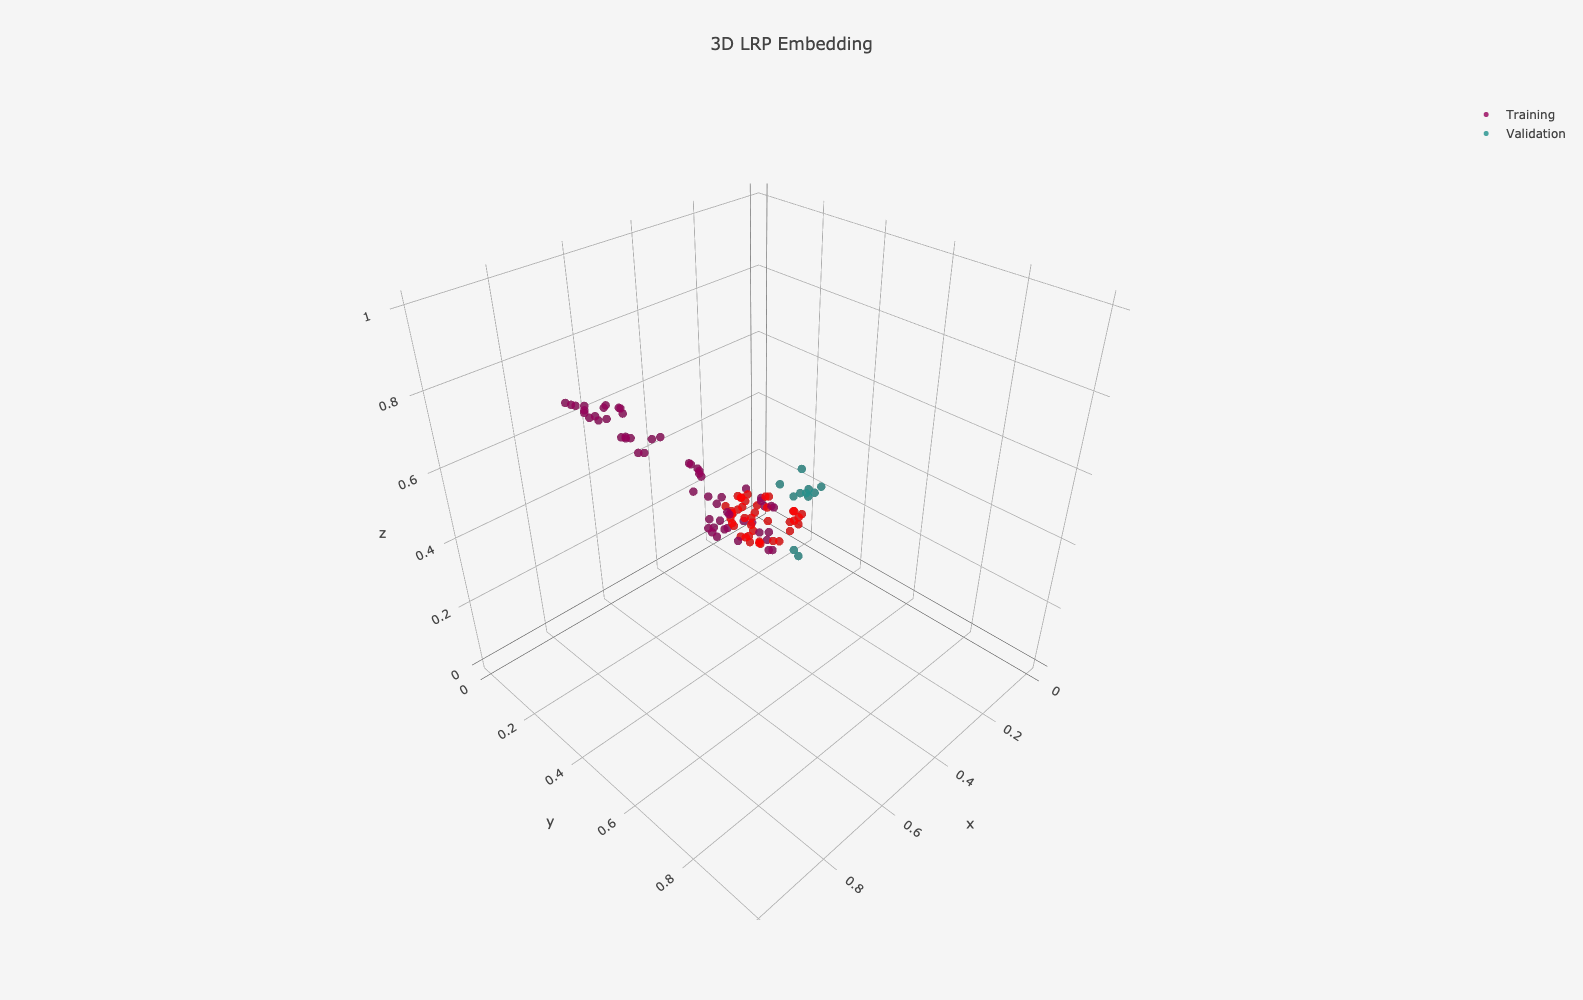

In [33]:
# pipeline.reducer_pipeline[0].n_neighbors
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)

embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5',
#     template="plotly"
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template="plotly")  /

iplot(fig, filename='lrp-3d-scatter.html')

# Performing Feature Reduction

In [35]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

## Getting largest subcluster samples from validation set

In [36]:
subcluster_labels = range(0,max(pipeline.clusterer.labels_)+1)

# Get testing samples from cross validation
reindexer = pipeline.testing_idxs

# That were correctly predicted
correct_preds = pipeline.correct_preds_bool_arr

# Separating Control from Target
target_samples  = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

target_class_features = X_train.iloc[reindexer][correct_preds][target_samples]
target_class_labels   = y_train.iloc[reindexer][correct_preds][target_samples]
target_class_features.head()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
122,55,1,140,217,0,111,1,3,0,5.6,0,0,0,1,1,0,0,0,0,1
24,60,1,130,206,0,132,1,2,2,2.4,0,0,0,1,0,0,1,0,0,1
137,35,1,120,198,0,130,1,2,0,1.6,0,0,0,1,1,0,0,0,0,1
79,58,1,150,270,0,111,1,1,0,0.8,0,0,0,1,0,0,1,0,0,1
120,63,0,150,407,0,154,0,2,3,4.0,0,0,0,1,0,0,1,0,0,1


In [50]:
target_class_features.shape

(98, 20)

In [69]:
pipeline.target_class

-2

In [70]:
target_size = len(target_class_labels)
control_features = X_train[y_train != pipeline.target_class][:target_size]
# control_features = control_features[:target_size]
control_labels = y_train[y_train != pipeline.target_class][:target_size]

correct_predictions_features = pd.concat([control_features, target_class_features], axis="index")
correct_predictions_labels = pd.concat([control_labels, target_class_labels], axis="index")

## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [43]:
cluster_train = {}

for cluster_label in subcluster_labels:
    
    tsamples = target_class_features[(pipeline.clusterer.labels_ == cluster_label)]
    tlabels  = target_class_labels[(pipeline.clusterer.labels_ == cluster_label)]


#     csamples = X_train.iloc[reindexer][correct_preds][control_samples]
    csamples = X_train[y_train != pipeline.target_class]
    csamples = csamples[:len(tsamples)]

    clabels = y_train.iloc[reindexer][correct_preds][control_samples]
    clabels = clabels[:len(tsamples)]
  
    _clustered = pd.DataFrame(training_lrp[(pipeline.clusterer.labels_ == cluster_label)],
                              columns = X_train.columns)
    
#     thresh = min(val_clustered.describe().loc["75%"])
    thresh = _clustered.max().min()
    print(thresh)
    reduced_cols = get_relevant_cols(_clustered, thresh=thresh).columns
    print(reduced_cols, len(reduced_cols))
    
    tsamples = tsamples[reduced_cols]
    csamples  = csamples[reduced_cols]
    
    # Now stack it with control values of same size...
    X_train_sc = pd.concat([csamples, tsamples], axis="index")
    y_train_sc = pd.concat([clabels, tlabels], axis="index")
    
    cluster_train[cluster_label] = (X_train_sc, y_train_sc)


0.045565728
Index(['age', 'sex', 'trestbps', 'chol', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3',
       'thal_7'],
      dtype='object') 16
0.018922377
Index(['sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_2', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2',
       'thal_3', 'thal_7'],
      dtype='object') 17


In [44]:
_clustered.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.004756,0.170442,0.111077,0.064876,0.024834,0.027739,0.143782,0.199785,1.146908,0.413744,0.055409,0.009934,0.132527,0.338997,0.051307,0.006795,0.083914,0.174822,0.002544,0.312869
std,0.012343,0.125435,0.156041,0.072927,0.036007,0.055224,0.169638,0.189459,0.283706,0.378238,0.018108,0.015789,0.050969,0.140889,0.045216,0.043507,0.072083,0.106670,0.005330,0.241408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.637341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126245,0.959064,0.000000,0.048193,0.000000,0.107138,0.283278,0.000000,0.000000,0.000000,0.131285,0.000000,0.000000
50%,0.000000,0.190578,0.057684,0.036024,0.000000,0.000000,0.096419,0.167404,1.105792,0.382379,0.052935,0.000000,0.127811,0.358432,0.046259,0.000000,0.083055,0.183745,0.000000,0.386102
75%,0.000000,0.249518,0.155165,0.106944,0.047100,0.030503,0.268161,0.238336,1.307680,0.638126,0.068995,0.017842,0.165644,0.438714,0.083099,0.000000,0.130806,0.267910,0.000433,0.463045
max,0.057444,0.410225,0.544472,0.219326,0.112866,0.246271,0.501297,0.893085,1.865714,1.410907,0.092646,0.057099,0.249167,0.607301,0.147476,0.278581,0.240207,0.361244,0.018922,0.727965


In [45]:
srtd_metrics = _clustered.describe().loc[["mean","75%","max"]].sort_values(by=["mean", "75%", "max"], axis=1)

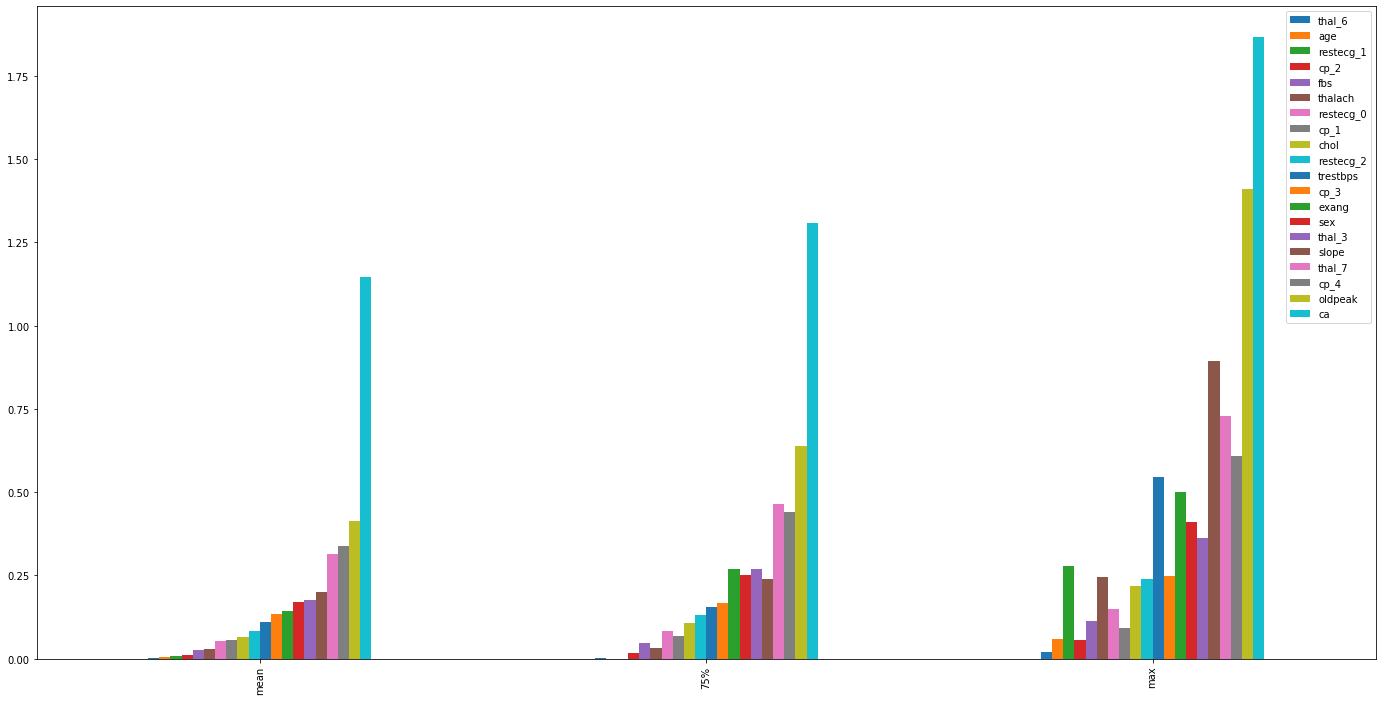

In [46]:
srtd_metrics.plot(kind="bar", figsize=(24,12))

### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [97]:
def runSubclusterAnalysis(cluster_train, dnn_build_fn, batch_size=20, epochs=100):
    results = {}
    
    for sc in cluster_train:
        X_train_sc, y_train_sc = cluster_train[sc]

        # All the samples from X_valid are used for now...
        X_valid_red = X_valid[X_train_sc.columns]

        nn = dnn_build_fn(num_features=X_train_sc.shape[1])

        _pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid_red, y_valid], target_class=1)
        _pipeline.train_model(batch_size=batch_size,epochs=epochs, cross_validation=True, parallel=False, verbose=0)

        _, cm = plot_confusion_matrix(y_train_sc.values[_pipeline.testing_idxs],
                              np.array(_pipeline.predictions, dtype=int),
                              np.array(["Normal", "Disease"]))
        results[sc] = cm
    
    correct = sum([np.trace(results[sc]) for sc in results])
    total   = sum([sum(results[sc].ravel()) for sc in results])
    print("Analysis Accuracy: {:.4f}".format(correct/total))
    
    return results

In [84]:
non_red_cluster_train = pipeline.getSubclusters(reduce=False)

# %time baseline_results = runSubclusterAnalysis(non_red_cluster_train, build_dnn)

# Feeding models (feature) reduced data

In [85]:
cluster_train = pipeline.getSubclusters(reduce=True)
print(cluster_train[0][0].columns)
print(cluster_train[1][0].columns)

Index(['age', 'sex', 'trestbps', 'chol', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3',
       'thal_7'],
      dtype='object')
Index(['sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'slope', 'ca',
       'oldpeak', 'cp_1', 'cp_2', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2',
       'thal_3', 'thal_7'],
      dtype='object')


## Original architecture

### Accuracy is same as w/ original feature set
> **This is a sign that the features dropped were in fact not very useful for classifying *this* subcluster**

In [86]:
# %time baseline_reduced_results = runSubclusterAnalysis(cluster_train, build_dnn)

# Shallow Network

## Rebuilding a (simpler) DNN architecture

In [87]:
def build_shallow_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 15, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 10, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=5, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

### Accuracy is same as w/ original architecture

- **Using a different network architecture removes any potential sources of bias of reusing the same samples for the same network**
- **Using a shallower n/w shows us that a "simpler" classifier can work**

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.377, Acc:0.9020
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.213 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.232, Acc:0.9608
Prediction Accuracy
12/12 [==============================] - 0s 49us/step
Scores on data set: loss=0.464 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.291, Acc:0.9216
Prediction Accuracy
12/12 [==============================] - 0s 38us/step
Scores on data set: loss=0.265 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.260, Acc:0.9216
Prediction Accuracy
12/12 [==============================] - 0s 56us/step
Scores on data set: loss=0.110 accuracy=1.0000
Fold Correct: 12
Running worker: 4
Fold: 4 -> Loss:0.270, Acc:0.9118
Prediction Accuracy
12/12 [==============================] - 0s 55us/step
Scores on data set: loss=0.599 accuracy=0.8333
Fold Correct: 10
Running worker: 5
Fo

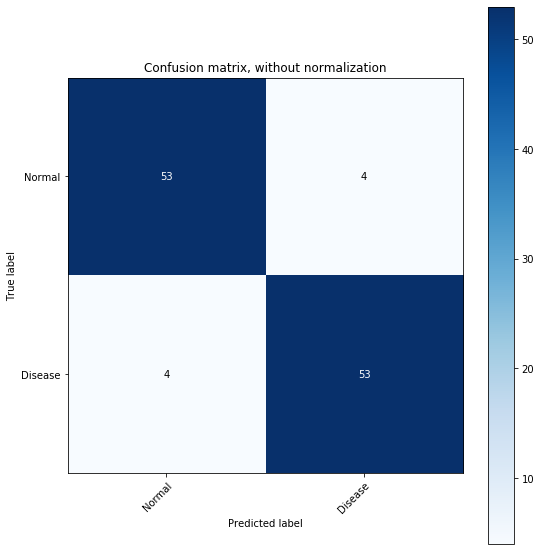

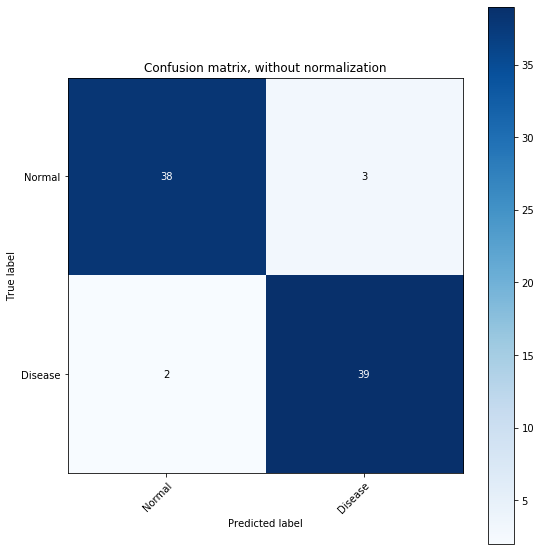

In [88]:
%time shallow_nw_results = runSubclusterAnalysis(cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

In [96]:
correct = sum([np.trace(shallow_nw_results[sc]) for sc in shallow_nw_results])
total = sum([sum(shallow_nw_results[sc].ravel()) for sc in shallow_nw_results])
print("Analysis Accuracy: {:.4f}".format(correct/total))

Analysis Accuracy: 0.9337


- ### Better accuracy than original architecure being fed reduced features
- # Generally beats original non-subclustered analysis
- ### Not as good as orginal with subclustered data
    - **Thats expected however due to the implicit bias in the subclusters**


## NN w/ ALL features
- ### Performs just as well as original architecure with subcluster

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.292, Acc:0.9510
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.121 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.356, Acc:0.9020
Prediction Accuracy
12/12 [==============================] - 0s 32us/step
Scores on data set: loss=0.456 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.366, Acc:0.9314
Prediction Accuracy
12/12 [==============================] - 0s 45us/step
Scores on data set: loss=0.300 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.294, Acc:0.9314
Prediction Accuracy
12/12 [==============================] - 0s 38us/step
Scores on data set: loss=0.123 accuracy=1.0000
Fold Correct: 12
Running worker: 4
Fold: 4 -> Loss:0.252, Acc:0.9314
Prediction Accuracy
12/12 [==============================] - 0s 41us/step
Scores on data set: loss=0.923 accuracy=0.8333
Fold Correct: 10
Running worker: 5
Fo

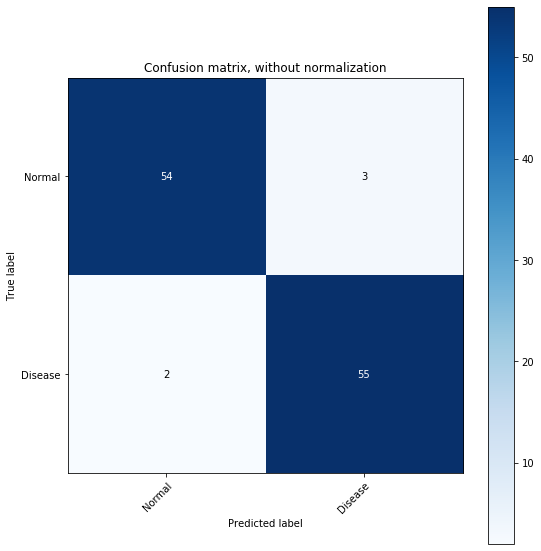

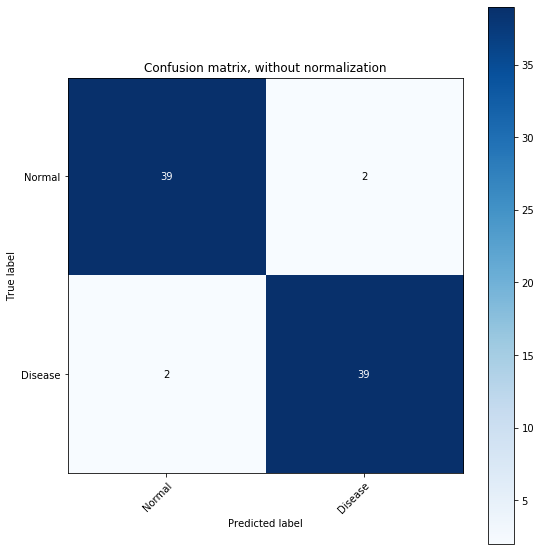

In [100]:
# non_red_cluster_train = pipeline.getSubclusters(reduce=False)
%time shallow_nw_results = runSubclusterAnalysis(non_red_cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

## NN w/ well biased (well-separated) samples

In [75]:
#### Skipping for now ####
nn = build_shallow_dnn(num_features=X_train.shape[1])

shallow_pipeline = ClusterPipeline(nn, [correct_predictions_features, correct_predictions_labels], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.247, Acc:0.9432
Prediction Accuracy
20/20 [==============================] - 0s 2ms/step
Scores on data set: loss=0.458 accuracy=0.8500
Fold Correct: 17
Running worker: 1
Fold: 1 -> Loss:0.248, Acc:0.9261
Prediction Accuracy
20/20 [==============================] - 0s 25us/step
Scores on data set: loss=0.211 accuracy=0.9500
Fold Correct: 19
Running worker: 2
Fold: 2 -> Loss:0.333, Acc:0.9261
Prediction Accuracy
20/20 [==============================] - 0s 30us/step
Scores on data set: loss=0.221 accuracy=0.9500
Fold Correct: 19
Running worker: 3
Fold: 3 -> Loss:0.257, Acc:0.9375
Prediction Accuracy
20/20 [==============================] - 0s 31us/step
Scores on data set: loss=0.326 accuracy=0.9500
Fold Correct: 19
Running worker: 4
Fold: 4 -> Loss:0.306, Acc:0.9375
Prediction Accuracy
20/20 [==============================] - 0s 32us/step
Scores on data set: loss=0.255 accuracy=0.9000
Fold Correct: 18
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.92857143 0.07142857]
 [0.08163265 0.91836735]]
Overall Accuracy: 0.9235


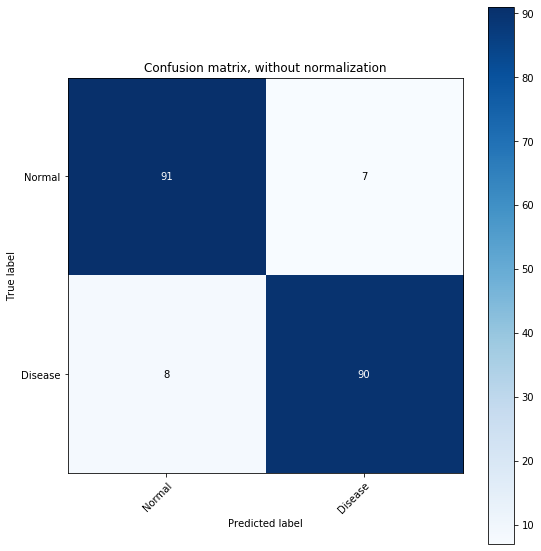

In [76]:
_,cm = plot_confusion_matrix(correct_predictions_labels.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

## Shallow on Original Network

In [98]:
nn = build_shallow_dnn(num_features=X_train.shape[1])

shallow_pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid, y_valid], target_class=1)

shallow_pipeline.train_model(batch_size=20,epochs=30, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.513, Acc:0.8488
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.379 accuracy=0.8929
Fold Correct: 25
Running worker: 1
Fold: 1 -> Loss:0.508, Acc:0.8333
Prediction Accuracy
28/28 [==============================] - 0s 18us/step
Scores on data set: loss=0.490 accuracy=0.7857
Fold Correct: 22
Running worker: 2
Fold: 2 -> Loss:0.513, Acc:0.8411
Prediction Accuracy
28/28 [==============================] - 0s 15us/step
Scores on data set: loss=0.599 accuracy=0.8214
Fold Correct: 23
Running worker: 3
Fold: 3 -> Loss:0.477, Acc:0.8682
Prediction Accuracy
27/27 [==============================] - 0s 13us/step
Scores on data set: loss=0.484 accuracy=0.8519
Fold Correct: 23
Running worker: 4
Fold: 4 -> Loss:0.431, Acc:0.8808
Prediction Accuracy
26/26 [==============================] - 0s 17us/step
Scores on data set: loss=0.902 accuracy=0.6923
Fold Correct: 18
Running worker: 5
Fo

Confusion matrix, without normalization
[[0.86111111 0.13888889]
 [0.20325203 0.79674797]]
Overall Accuracy: 0.8315


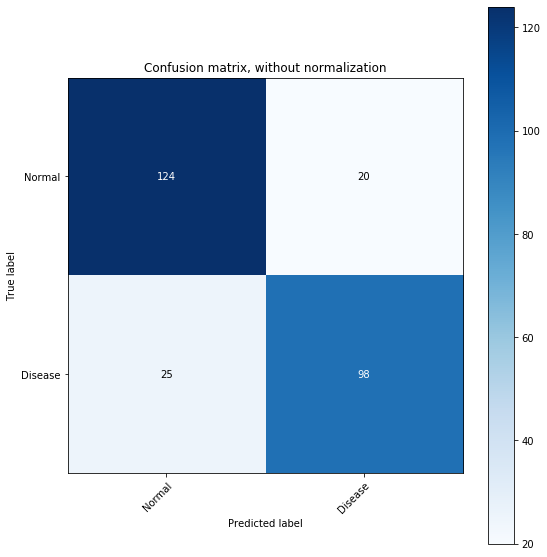

In [99]:
_,cm = plot_confusion_matrix(y_train.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

# SVM Analysis

In [120]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()


clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

def runSVM(X,y, X_valid,y_valid):
    np.random.seed(42)
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, _score.mean()

## SVM trained on original data

In [111]:
original_svm, score = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.846(+/- 0.143)


## SVM trained on biased data

In [112]:
original_svm, score = runSVM(correct_predictions_features, correct_predictions_labels, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.733
SVM CV Accuracy: 0.943(+/- 0.073)


## Trained on subcluster vs control only

In [121]:
%%time 
scores = []
sizes = []

for sc in non_red_cluster_train:
    X_train_sc, y_train_sc = non_red_cluster_train[sc]
    X_valid_red = X_valid[X_train_sc.columns]
    _clf, _score = runSVM(X_train_sc, y_train_sc, X_valid_red, y_valid)
    scores.append(_score)
    sizes.append(len(X_train_sc))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.947(+/- 0.088)
{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.963(+/- 0.115)
CPU times: user 412 ms, sys: 8.61 ms, total: 421 ms
Wall time: 4.3 s


In [122]:
# This is actually the "true" mean: sum(correctly classified) / (total samples)
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes, scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

Weighted Mean: 0.9533


## Trained on feature reduced subcluster
> ### Despite losing some features, we still retain a high accuracy
> ### This may be an indication that the subclustering was infact a valid one

In [123]:
scores = []
sizes  = []

for sc in cluster_train:
    X_train_sc, y_train_sc = cluster_train[sc]
    X_valid_red = X_valid[X_train_sc.columns]
    _clf, _score = runSVM(X_train_sc, y_train_sc, X_valid_red, y_valid)
    scores.append(_score)
    sizes.append(len(X_train_sc))

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.938(+/- 0.111)
{'C': 10, 'dual': False, 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}
SVM Test Accuracy: 0.733
SVM CV Accuracy: 0.975(+/- 0.100)


In [124]:
weighted_avg = sum([sz*sc.mean() for sz,sc in zip(sizes, scores)])/sum(sizes)
print("Weighted Mean: {:0.4f}".format(weighted_avg))

Weighted Mean: 0.9537
